<a href="https://colab.research.google.com/github/jpanda001/Artistic-Style-Transfer/blob/jyoti/Main_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
vgg = models.vgg19(pretrained=True).features.cuda() #only the features portion
for parameter in vgg.parameters(): #Fix vgg network parameters
  parameter.requires_grad_(False)

  
  #MOVE VGG to GPU


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:11<00:00, 50478405.73it/s]


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#LOAD STYLE AND CONTENT IMAGES AND NORMALIZE THEM TO NORMALIZED TENSORS
def load_and_normalize(img_path, img_size=256):   
    image = Image.open(img_path)    
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = transform(image)[:,:].unsqueeze(0)
    
    
    return image

In [0]:
image = Image.open('/content/gdrive/My Drive/APS360_Style_Transfer/Curated_data/Content_images/test/content (318).jpg')
transform = transforms.ToTensor()
image = transform(image)
print(image.shape)

torch.Size([3, 256, 256])


In [0]:
content_img = load_and_normalize('/content/gdrive/My Drive/APS360_Style_Transfer/Curated_data/Content_images/test/content (318).jpg')
style_img = load_and_normalize('/content/gdrive/My Drive/APS360_Style_Transfer/Curated_data/Style_images/media_oilpaint/test/865.jpg')
target_img = content_img.clone().requires_grad_(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


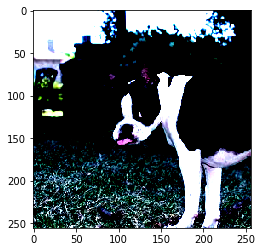

In [0]:
img = np.transpose(content_img.squeeze(0), [1,2,0])
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


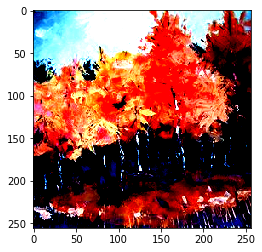

In [0]:
img = np.transpose(style_img.squeeze(0), [1,2,0])
plt.imshow(img)

In [0]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
for index, name in vgg._modules.items():
  print(index, name)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
20 ReLU

In [0]:
def get_style_rep(image):
  layer = {'0': 'conv1_1',
           '5': 'conv2_1', 
           '10': 'conv3_1', 
           '19': 'conv4_1',
           '28': 'conv5_1'}
        
  rep = {}
  i = image.cuda()                           
  for index, name in vgg._modules.items(): #holds modules in the model
      i = name(i)
      if index in layer:
        rep[layer[index]] = i           
  return rep

def get_content_rep(image):
  layer = {'21': 'conv4_2',  # content representation layer as suggested by the paper
           }
        
  rep = {}
  i = image.cuda()                           
  for index, name in vgg._modules.items(): #holds modules in the model
      i = name(i)
      if index in layer:
        rep[layer[index]] = i           
  return rep

def get_target_rep(image):
  layer = {'0': 'conv1_1',
           '5': 'conv2_1', 
           '10': 'conv3_1', 
           '19': 'conv4_1',
           '21': 'conv4_2',
           '28': 'conv5_1'}
        
  rep = {}
  i = image.cuda()                           
  for index, name in vgg._modules.items(): #holds modules in the model
      i = name(i)
      if index in layer:
        rep[layer[index]] = i           
  return rep

In [0]:
def gram_matrix(tensor):
    # NCWH of the input
    n, c, h, w = tensor.size()
    #resize
    features = tensor.view(n * c, h * w) 
    # Gram product
    G = torch.mm(features, features.t())
    #normalize product
    gm = G.div(n * c * h * w)
    
    return gm

In [0]:
def get_content_loss(content, target):
  loss = F.mse_loss(content, target)
  return loss

def get_style_loss(style_g, target_g):
  loss = F.mse_loss(style_g,target_g)
  return loss

In [0]:

content_rep = get_content_rep(content_img) #load and normalize img first
style_rep = get_style_rep(style_img)


In [0]:
style_gs = {layer: gram_matrix(style_rep[layer]) for layer in style_rep}
print(style_gs)

{'conv1_1': tensor([[1.3844e-03, 5.9849e-04, 1.3533e-04,  ..., 1.1204e-03, 3.8186e-04,
         8.2770e-04],
        [5.9849e-04, 1.0909e-02, 5.8283e-04,  ..., 1.2354e-03, 2.0551e-03,
         3.8267e-03],
        [1.3533e-04, 5.8283e-04, 8.0557e-04,  ..., 5.6036e-05, 5.0078e-04,
         9.3550e-04],
        ...,
        [1.1204e-03, 1.2354e-03, 5.6036e-05,  ..., 3.0703e-03, 1.2055e-03,
         1.5393e-03],
        [3.8186e-04, 2.0551e-03, 5.0078e-04,  ..., 1.2055e-03, 2.6663e-03,
         2.0838e-03],
        [8.2770e-04, 3.8267e-03, 9.3550e-04,  ..., 1.5393e-03, 2.0838e-03,
         5.6426e-03]], device='cuda:0'), 'conv2_1': tensor([[0.0180, 0.0020, 0.0136,  ..., 0.0046, 0.0004, 0.0059],
        [0.0020, 0.0071, 0.0050,  ..., 0.0044, 0.0008, 0.0013],
        [0.0136, 0.0050, 0.0471,  ..., 0.0082, 0.0011, 0.0110],
        ...,
        [0.0046, 0.0044, 0.0082,  ..., 0.0185, 0.0022, 0.0027],
        [0.0004, 0.0008, 0.0011,  ..., 0.0022, 0.0044, 0.0024],
        [0.0059, 0.0013, 0.011

In [0]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


In [0]:
tra = TransformerNet()
a = torch.randn(1,3,256,256)
b = tra(a)
print(a.shape)
print(b.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [0]:
def train(target_img):
  interval = 500
  iteration = 20000
  betas = {'conv1_1': 1.,
           'conv2_1': 0.8,
           'conv3_1': 0.3,
           'conv4_1': 0.25,
           'conv5_1': 0.2}

  alpha = 1
  beta = 1000000
  transformer = TransformerNet().cuda()
  optimizer = optim.Adam([target_img], lr=0.005)
  transformer.train()
  for i in range(1, iteration+1):
    optimizer.zero_grad()
    #transformed_img = transformer(target_img.cuda())
    target_reps = get_target_rep(transformed_img)
    s_loss = 0
    c_loss = get_content_loss(content_rep['conv4_2'],target_reps['conv4_2'])
    for layer in betas:
      target_rep = target_reps[layer]
      n = target_rep.shape[0]
      c = target_rep.shape[1]
      h = target_rep.shape[2]
      w = target_rep.shape[3]
      target_g = gram_matrix(target_rep)
      style_g  = style_gs[layer]
      s_loss_temp = betas[layer]*get_style_loss(style_g, target_g)
      s_loss += s_loss_temp
      
    loss = alpha * c_loss + beta * s_loss
    loss.backward(retain_graph=True)
    optimizer.step()
    
    
    if i % interval == 0:
      print('current iter:{} current loss:{} '.format(i, loss.item()))
      img = transformed_img.to("cpu").detach()
      img = img.numpy().squeeze()
      img = img.transpose(1,2,0)
      img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
      img = img.clip(0, 1)
      plt.imshow(img)
      plt.show()
      
  

current iter:500 current loss:41.678466796875 


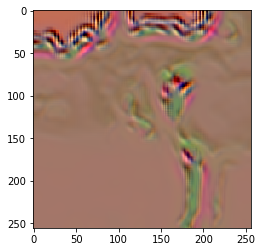

current iter:1000 current loss:14.370960235595703 


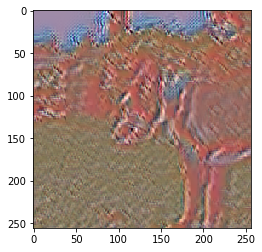

current iter:1500 current loss:9.528424263000488 


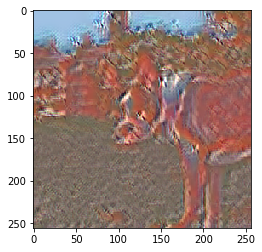

current iter:2000 current loss:8.773567199707031 


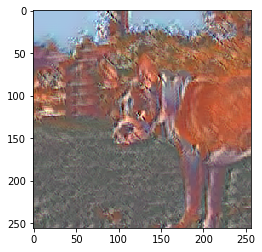

current iter:2500 current loss:6.97863245010376 


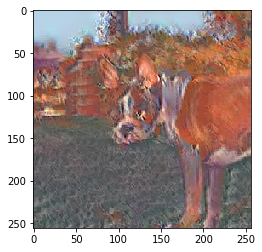

current iter:3000 current loss:5.661036491394043 


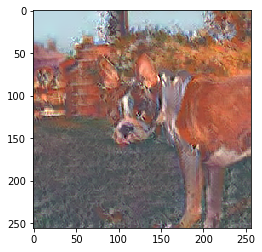

current iter:3500 current loss:5.096837520599365 


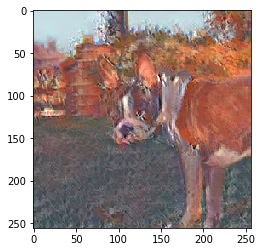

current iter:4000 current loss:4.560415744781494 


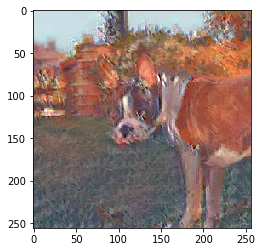

current iter:4500 current loss:4.076170444488525 


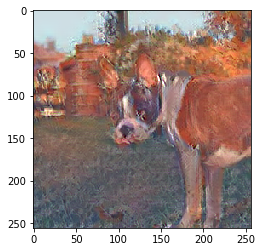

current iter:5000 current loss:4.3611979484558105 


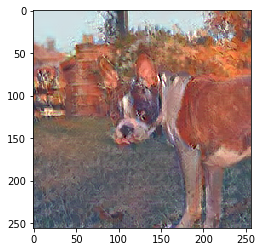

current iter:5500 current loss:4.083737373352051 


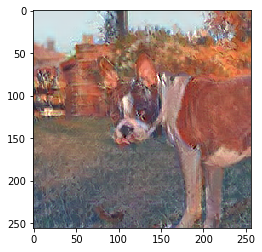

current iter:6000 current loss:3.637284278869629 


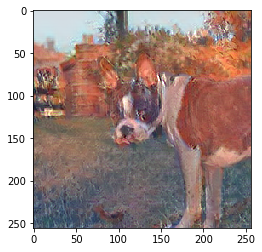

current iter:6500 current loss:3.3693206310272217 


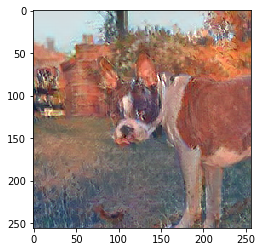

current iter:7000 current loss:3.5307559967041016 


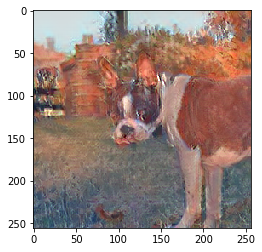

current iter:7500 current loss:3.189305305480957 


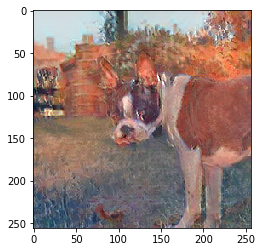

current iter:8000 current loss:3.0373270511627197 


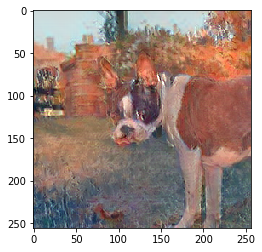

current iter:8500 current loss:2.9158596992492676 


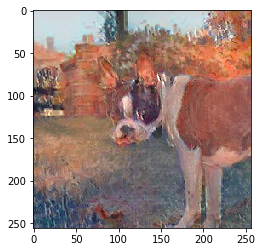

current iter:9000 current loss:5.962735652923584 


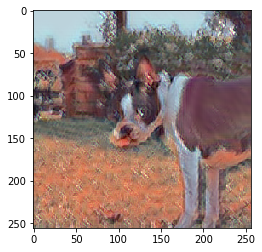

current iter:9500 current loss:3.8135392665863037 


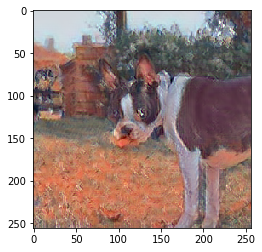

current iter:10000 current loss:3.3119120597839355 


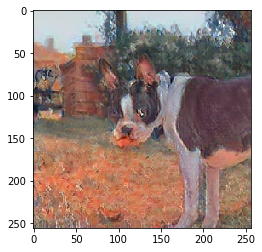

current iter:10500 current loss:2.9645609855651855 


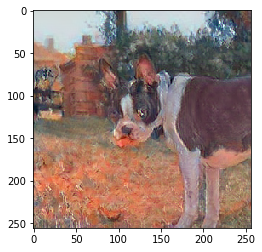

current iter:11000 current loss:2.8829290866851807 


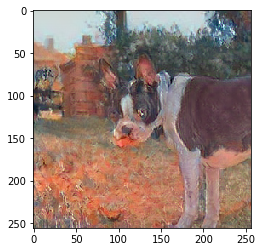

current iter:11500 current loss:3.1155428886413574 


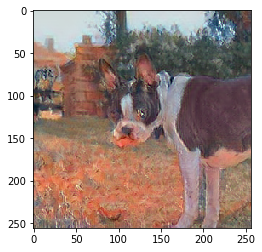

current iter:12000 current loss:2.703909397125244 


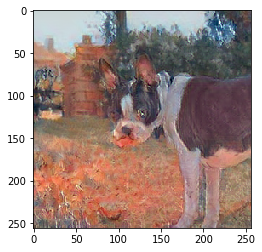

current iter:12500 current loss:2.585249900817871 


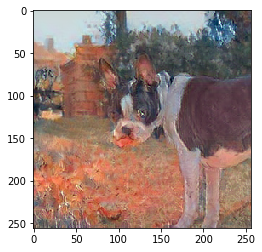

current iter:13000 current loss:2.6009063720703125 


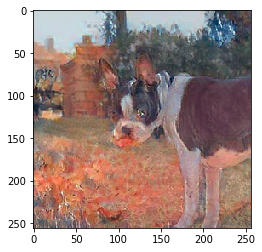

current iter:13500 current loss:2.4917843341827393 


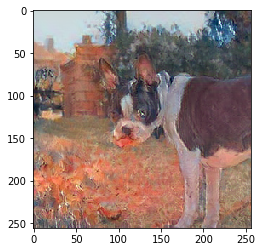

current iter:14000 current loss:2.5077013969421387 


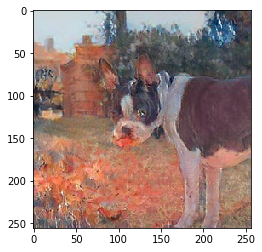

current iter:14500 current loss:2.632737159729004 


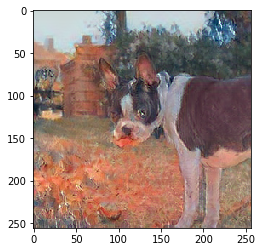

current iter:15000 current loss:2.5031402111053467 


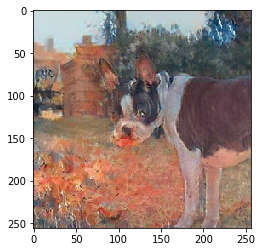

current iter:15500 current loss:2.386739492416382 


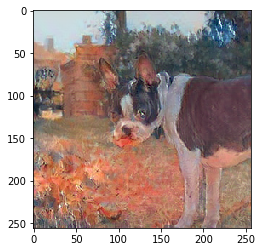

current iter:16000 current loss:2.380906581878662 


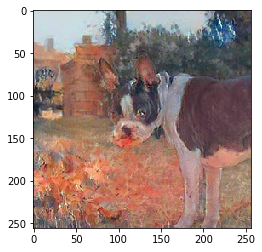

current iter:16500 current loss:10.42561149597168 


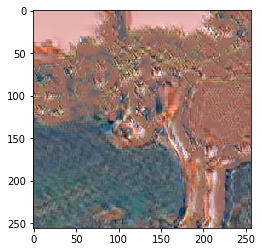

current iter:17000 current loss:6.380588531494141 


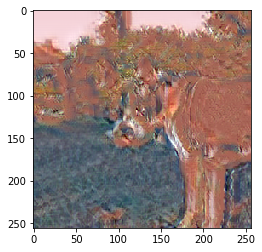

current iter:17500 current loss:4.954662322998047 


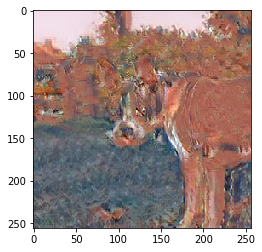

current iter:18000 current loss:4.3797807693481445 


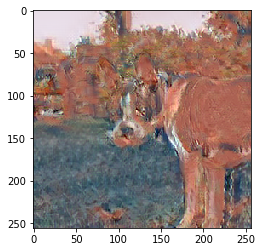

current iter:18500 current loss:3.9747583866119385 


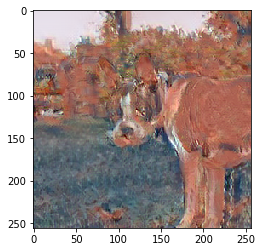

current iter:19000 current loss:3.6757659912109375 


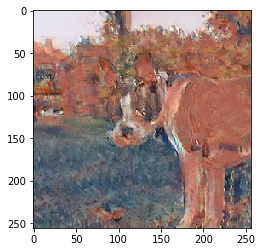

current iter:19500 current loss:3.5266571044921875 


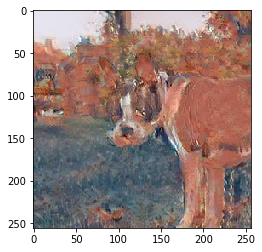

current iter:20000 current loss:3.3911454677581787 


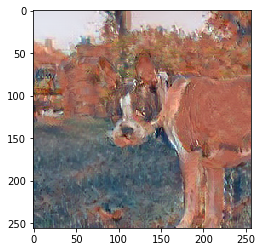

In [0]:
train(target_img)

In [0]:
class Transformer(nn.Module):  # A ResNet Architecture
    def __init__(self):
        super(Transformer, self).__init__()
        self.transform = nn.Sequential(
            Conv(3, 32, kernel_size=9, stride=1),
            Conv(32, 64, kernel_size=3, stride=2),
            Conv(64, 128, kernel_size=3, stride=2),
            Res(128),
            Res(128),
            Res(128),
            Res(128),
            Res(128),
            Conv(128, 64, kernel_size=3, upsample=True),
            Conv(64, 32, kernel_size=3, upsample=True),
            Conv(32, 3, kernel_size=9, stride=1, normalize=False, relu=False)
        )

    def forward(self, x):
        return self.transform(x)


class Res(nn.Module):
    def __init__(self, channels):
        super(Res, self).__init__()
        self.block = nn.Sequential(
            Conv(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            Conv(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(Conv, self).__init__()
        self.upsample = upsample
        self.con = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True)
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.con(x)
        if self.norm:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

In [0]:
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import utils
from transformer_net import TransformerNet
from vgg import Vgg16


def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)


def train(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = utils.load_image(args.style_image, size=args.style_size)
    style = style_transform(style)
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    features_style = vgg(utils.normalize_batch(style))
    gram_style = [utils.gram_matrix(y) for y in features_style]

    for e in range(args.epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = utils.normalize_batch(y)
            x = utils.normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= args.style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % args.log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if args.checkpoint_model_dir is not None and (batch_id + 1) % args.checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(args.checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                transformer.to(device).train()

    # save model
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(args.epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
        args.content_weight) + "_" + str(args.style_weight) + ".model"
    save_model_path = os.path.join(args.save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)


def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = utils.load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if args.model.endswith(".onnx"):
        output = stylize_onnx_caffe2(content_image, args)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(args.model)
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)
            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, args.export_onnx).cpu()
            else:
                output = style_model(content_image).cpu()
    utils.save_image(args.output_image, output[0])


def stylize_onnx_caffe2(content_image, args):
    """
    Read ONNX model and run it using Caffe2
    """

    assert not args.export_onnx

    import onnx
    import onnx_caffe2.backend

    model = onnx.load(args.model)

    prepared_backend = onnx_caffe2.backend.prepare(model, device='CUDA' if args.cuda else 'CPU')
    inp = {model.graph.input[0].name: content_image.numpy()}
    c2_out = prepared_backend.run(inp)[0]

    return torch.from_numpy(c2_out)


def main():
    main_arg_parser = argparse.ArgumentParser(description="parser for fast-neural-style")
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--epochs", type=int, default=2,
                                  help="number of training epochs, default is 2")
    train_arg_parser.add_argument("--batch-size", type=int, default=4,
                                  help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images/style-images/mosaic.jpg",
                                  help="path to style-image")
    train_arg_parser.add_argument("--save-model-dir", type=str, required=True,
                                  help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None,
                                  help="path to folder where checkpoints of trained models will be saved")
    train_arg_parser.add_argument("--image-size", type=int, default=256,
                                  help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None,
                                  help="size of style-image, default is the original size of style image")
    train_arg_parser.add_argument("--cuda", type=int, required=True,
                                  help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42,
                                  help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5,
                                  help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10,
                                  help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3,
                                  help="learning rate, default is 1e-3")
    train_arg_parser.add_argument("--log-interval", type=int, default=500,
                                  help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-interval", type=int, default=2000,
                                  help="number of batches after which a checkpoint of the trained model will be created")

    eval_arg_parser = subparsers.add_parser("eval", help="parser for evaluation/stylizing arguments")
    eval_arg_parser.add_argument("--content-image", type=str, required=True,
                                 help="path to content image you want to stylize")
    eval_arg_parser.add_argument("--content-scale", type=float, default=None,
                                 help="factor for scaling down the content image")
    eval_arg_parser.add_argument("--output-image", type=str, required=True,
                                 help="path for saving the output image")
    eval_arg_parser.add_argument("--model", type=str, required=True,
                                 help="saved model to be used for stylizing the image. If file ends in .pth - PyTorch path is used, if in .onnx - Caffe2 path")
    eval_arg_parser.add_argument("--cuda", type=int, required=True,
                                 help="set it to 1 for running on GPU, 0 for CPU")
    eval_arg_parser.add_argument("--export_onnx", type=str,
                                 help="export ONNX model to a given file")

    args = main_arg_parser.parse_args()

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)

    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)


if __name__ == "__main__":
    main()

In [0]:
import torch


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out